# Fashion MNIST - A Marketing stunt by Zolando

Source: 

https://www.kaggle.com/girishgupta/fashion-mnist-using-resnet

![resnet](https://www.researchgate.net/publication/322621180/figure/fig2/AS:584852684410885@1516451154473/The-representation-of-model-architecture-image-for-ResNet-152-VGG-19-and-two-layered.png)

In [19]:
%%capture install_pandas

!pip install pandas

In [20]:
import tensorflow
from tensorflow import keras

In [21]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from keras import backend as K
from keras.models import Model

In [22]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
train_data = pd.read_csv("./data/fashion-mnist_train.csv")
test_data = pd.read_csv("./data/fashion-mnist_test.csv")

In [24]:
X_train = train_data.iloc[:,1:].values
Y_train = train_data.label.values

X_test = test_data.iloc[:,1:].values
Y_test = test_data.label.values

print(X_test.shape, X_train.shape)

(10000, 784) (60000, 784)


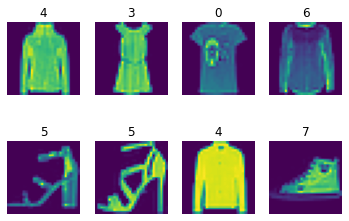

In [25]:
sample = np.random.randint(0,high= 59999, size=8)

sample_img = X_train[sample, :]
sample_label = Y_train[sample]
for i , img in enumerate(sample_img):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    plt.title(sample_label[i])
    img = img.reshape(28,28)
    plt.imshow(img)
plt.show()

In [26]:
#Defining constants
epochs = 3
batch_size = 512
img_size = 28

num_classes = 10

num_filters = 16
num_blocks = 3
num_sub_blocks = 2

use_max_pool = False

In [27]:
x_train = X_train.reshape(X_train.shape[0],img_size,img_size,1)
x_test = X_test.reshape(X_test.shape[0],img_size,img_size,1)

input_size = (img_size, img_size,1)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Y_train shape: (60000,)


In [28]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 14, 14, 16)   800         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 14, 14, 16)   64          conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 14, 14, 16)   0           batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [29]:
loss_graph = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/3
118/118 [==============================] - 29s 235ms/step - loss: 0.7311 - accuracy: 0.7828 - val_loss: 0.8132 - val_accuracy: 0.7858
Epoch 2/3
118/118 [==============================] - 28s 237ms/step - loss: 0.4548 - accuracy: 0.8737 - val_loss: 0.5219 - val_accuracy: 0.8562
Epoch 3/3
118/118 [==============================] - 29s 249ms/step - loss: 0.3984 - accuracy: 0.8929 - val_loss: 0.4287 - val_accuracy: 0.8805


<AxesSubplot:>

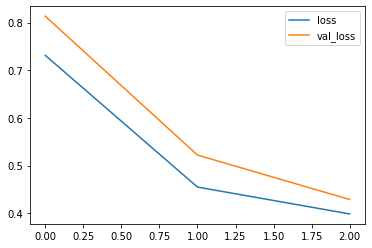

In [30]:
pd.DataFrame( loss_graph.history )[['loss', 'val_loss']].plot()

<AxesSubplot:>

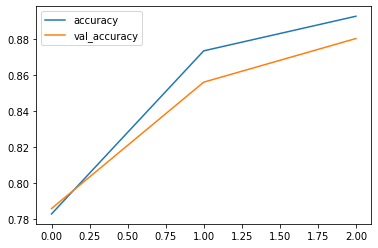

In [31]:
pd.DataFrame( loss_graph.history )[['accuracy', 'val_accuracy']].plot()